# $\mathrm{O_3}$

In [2]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [85]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [155]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [122]:
h5_path = "../../data/photolysis_data.h5" 
species = "O3" 
rxns = relevant_rxns(h5_path, species)

9-element Vector{Any}:
 "BrONO2  to  Br and NO3"
 "ClONO2  to  Cl and NO3"
 "IONO2  to  I and NO3"
 "N2O5  to  NO3 and NO and O(3P)"
 "N2O5  to  NO3 and NO2"
 "NO3  to  NO and O2"
 "NO3  to  NO2 and O"
 "NO3  to  total"
 "O3  to  O(1D) and O2"

In [123]:
rxn = rxns[end]

"O3  to  O(1D) and O2"

In [124]:
λs, Φs, T1s, T2s, species, source_idx, T_units, category, reaction, λ_units, Φ_units  = get_raw_data(h5_path, rxn)

([300.0, 302.5, 305.0, 306.0, 307.0, 308.0, 309.0, 310.0, 311.0, 312.0  …  316.0, 317.0, 318.0, 319.0, 319.5, 320.0, 320.5, 321.0, 322.5, 325.0], [0.94, 1.0, 0.98, 0.93, 0.83, 0.79, 0.68, 0.48, 0.4, 0.3  …  0.24, 0.25, 0.23, 0.22, 0.23, 0.21, 0.09, 0.1, 0.11, 0.08], [298.0, 298.0, 227.0, 298.0, 273.0, 295.0, 298.0, 295.0, 203.0, 223.0  …  227.0, 295.0, 203.0, 223.0, 253.0, 273.0, 298.0, 321.0, 295.0, 295.0], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  29, 29, 29, 29, 29, 29, 29, 29, 29, 29], "K", "Ozone", "O3 → O(1D)+O2", "nm", "")

In [125]:
unique(species)

2-element Vector{Int64}:
 1
 2

In [126]:
reaction

"O3 → O(1D)+O2"

Based on the mcm Photolysis entry for $\mathrm{O_3}$, it appears we want the quantum yields for the production of $\mathrm{O(^1D)}$. The rate for $\mathrm{O(^3P)}$ is then defined as $1.0$ minus the $\mathrm{O(^1D)}$ rate [(based on this data)](http://chmlin9.leeds.ac.uk/MCMv3.3.1/parameters/photolysis/O3/o3_o3p_matsumi02_qy_298.txt).

In [127]:
species_to_use = 1 
df = data_to_df(λs, Φs, T1s, T2s, source_idx, species, species_to_use)

Row,λ,Φ,T,source_id
,Float64,Float64,Float64,Int64
1,300.0,0.94,298.0,1
2,302.5,1.0,298.0,1
3,305.0,0.98,298.0,1
4,306.0,0.93,298.0,1
5,307.0,0.83,298.0,1
6,308.0,0.79,298.0,1
7,309.0,0.68,298.0,1
8,310.0,0.48,298.0,1
9,311.0,0.4,298.0,1


In [128]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [129]:
unique(df.T)
unique(df.source_id)

n_sources = size(unique(df.source_id),1)

source_colors = distinguishable_colors(n_sources)

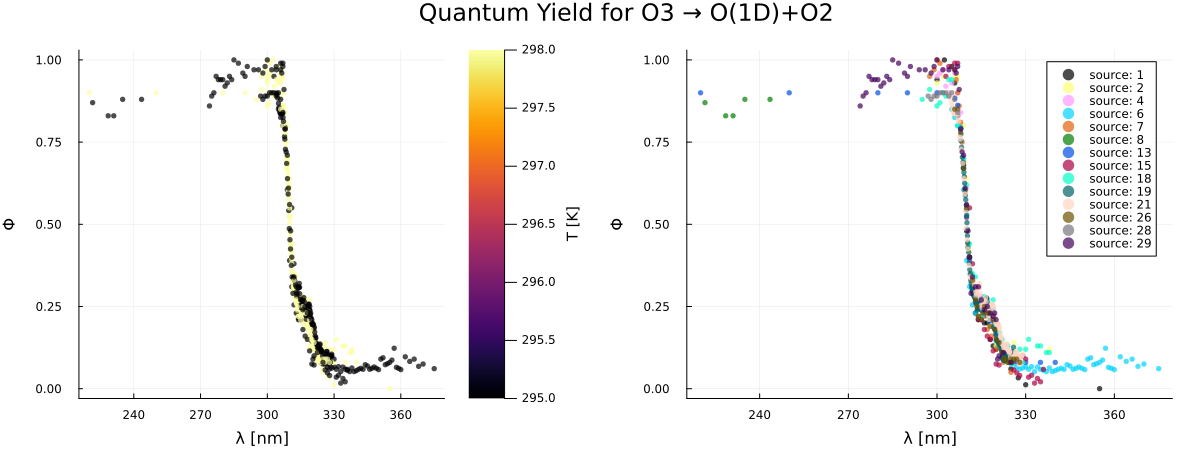

In [130]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    df.Φ[1:nskip:end],
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


gdf = groupby(df, :source_id)
p3 = plot()
i = 1
for df_g ∈ gdf 
    scatter!(
        df_g.λ[1:nskip:end],
        df_g.Φ[1:nskip:end],
        color = source_colors[i],
        ms=3, 
        msw=0,
        xlabel="λ [$(λ_units)]",
        ylabel="Φ",
        alpha=0.7,
        label="source: $(df_g.source_id[1])",
    )
    i += 1 
end

plot(p2, p3, layout=(1,2), size=(1200, 450), margin=5Plots.mm, plot_title="Quantum Yield for $(reaction)",)

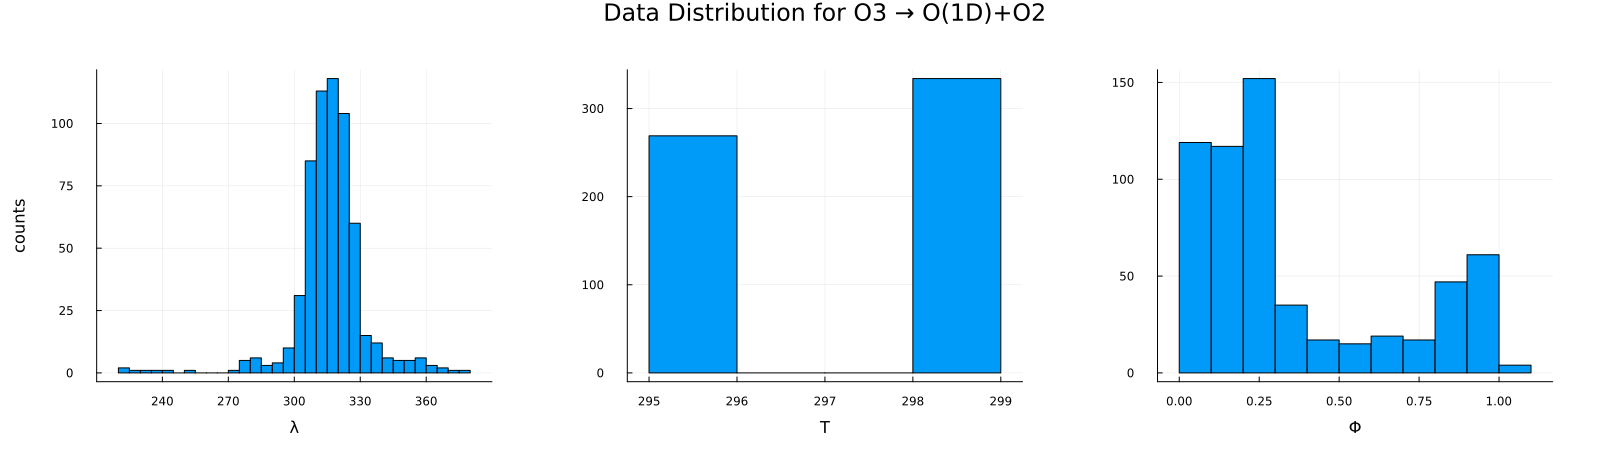

In [131]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(df.Φ, xlabel="Φ", label="", margin=10Plots.mm)
phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(reaction)")

# Data Preprocessing

In [132]:
gdfs = groupby(df, :T)

res_dfs = [] 

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:Φ, :T] .=> mean, renamecols=false))
end

df_unique = vcat(res_dfs...)

Row,λ,Φ,T
,Float64,Float64,Float64
1,305.0,0.875,295.0
2,306.0,0.91625,295.0
3,307.0,0.9025,295.0
4,308.0,0.791667,295.0
5,309.0,0.6575,295.0
6,310.0,0.475,295.0
7,311.0,0.42,295.0
8,312.0,0.325,295.0
9,313.0,0.273333,295.0


In [133]:
# λ_idxs = representative_rand_sample(df_unique.λ, 1000, 1500)
# Φ_idxs = representative_rand_sample(df_unique.Φ, 500, 2000) 
# idxs_res = shuffle(unique(vcat(λ_idxs, σ_idxs)))
# df_sampled = df_unique[idxs_res, :]

df_sampled = df_unique
max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

220.0

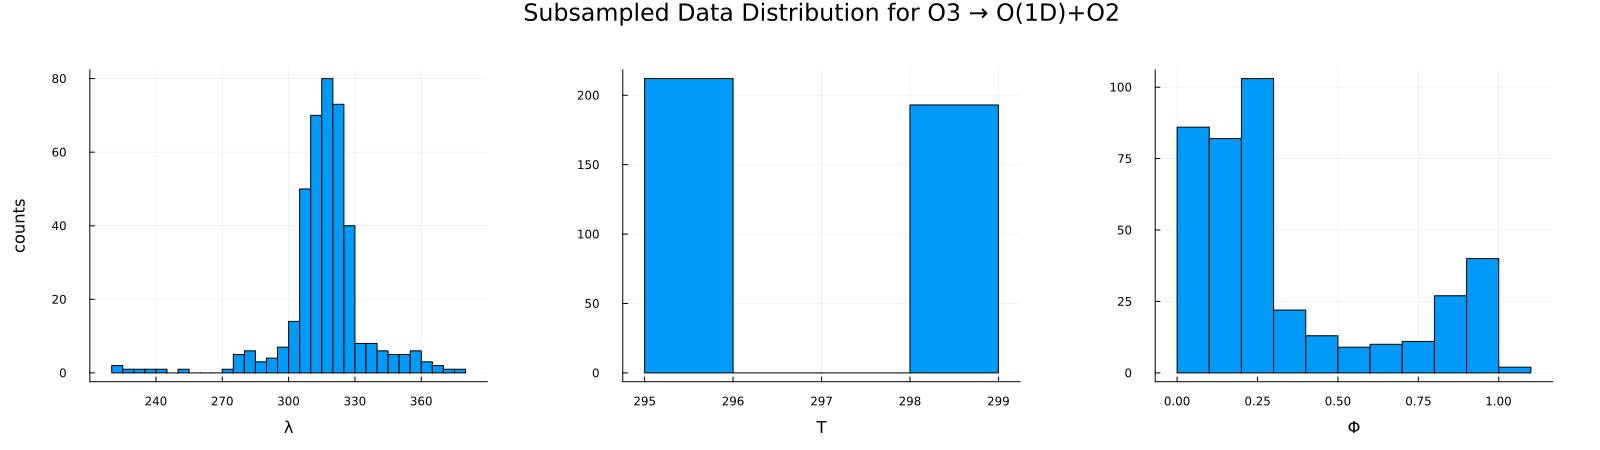

In [135]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(df_sampled.Φ, xlabel="Φ", label="", margin=10Plots.mm)

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(reaction)")

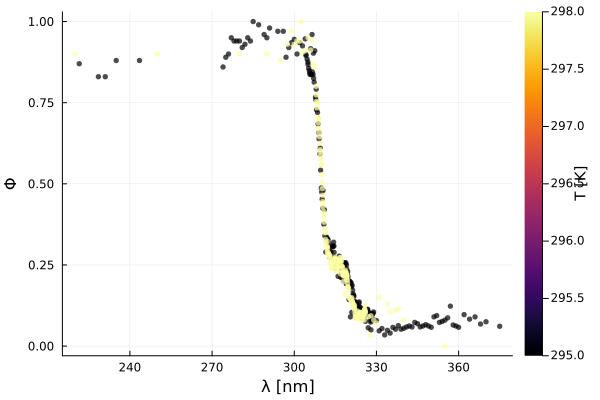

In [136]:
p2 = scatter(
    df_sampled.λ,
    df_sampled.Φ,
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


# GPR Fit

In [138]:
train_frac = 0.95
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

384


In [139]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = df_sampled.Φ[idxs_train]
ytest = df_sampled.Φ[idxs_test]

21-element Vector{Float64}:
 0.19933333333333328
 0.23
 0.203
 0.10500000000000001
 0.08
 0.113
 0.91
 0.279
 0.319
 0.5597777777777778
 0.09
 0.89
 0.11
 0.262
 0.1433333333333333
 0.97
 0.215
 0.09066666666666667
 0.226
 0.117
 0.052

In [140]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
SNR = 5 
σf² = var(ytrain)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))


function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [141]:
μ_init = 0.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = 0.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-2.4105710502039757, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(2.926368788321603, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(0.40541070008827546, exp, 1.4901161193847656e-8)), 
  σ² = 0.0035905614029058037, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [142]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = 0.0, …), …).


Iter     Function value   Gradient norm 
     0    -4.191613e+02     1.857660e+02
 * time: 0.016662120819091797
     1    -5.298949e+02     1.482540e+02
 * time: 1.251326084136963
     2    -7.574458e+02     6.005450e+01
 * time: 1.332585096359253
     3    -7.628352e+02     4.002571e+01
 * time: 1.3574740886688232
     4    -7.705375e+02     3.274217e+01
 * time: 1.3828082084655762
     5    -7.730034e+02     1.846344e+01
 * time: 1.4250340461730957
     6    -7.800252e+02     4.456137e+01
 * time: 1.4733691215515137
     7    -7.924565e+02     2.158277e+01
 * time: 1.5298571586608887
     8    -7.938999e+02     4.599406e+00
 * time: 1.5569190979003906
     9    -7.939712e+02     1.417196e+00
 * time: 1.584658145904541
    10    -7.940202e+02     2.920301e+00
 * time: 1.622941017150879
    11    -7.940394e+02     1.295449e-01
 * time: 1.665553092956543
    12    -7.940395e+02     2.831403e-03
 * time: 1.6918590068817139
    13    -7.940395e+02     3.434040e-05
 * time: 1.7276840209960

trained Machine; caches model-specific representations of data
  model: GPR(μ = 0.0, …)
  args: 
    1:	Source @769 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @778 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [143]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [-1.5645150951642488, 1.3965812753366507, 3.3544001106424104, -7.723780258456124],
 minimum = -794.039453057912,
 iterations = 20,
 converged = true,)

In [144]:
fp =fitted_params(mach)

(θ_best = [:σf² => 0.2091894404488177, :ℓ_λ => 4.041360040558239, :ℓ_T => 28.62842516578881],
 σ² = 0.00044220076473285876,)

In [145]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

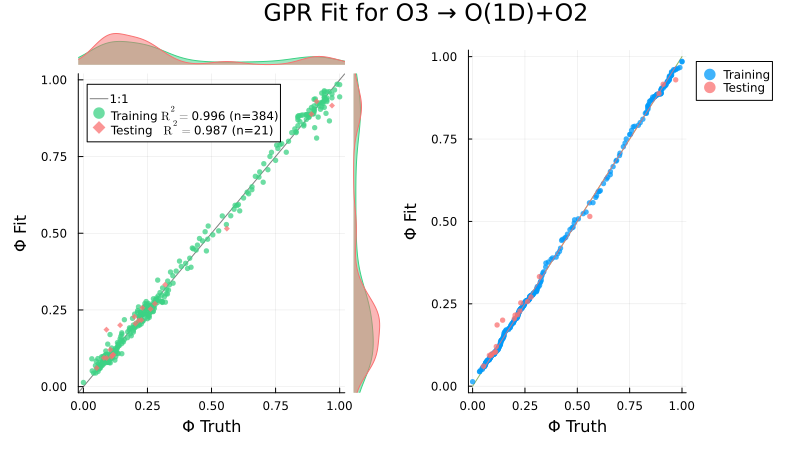

In [153]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="Φ Truth",
    ylabel="Φ Fit",
)

p2 = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="Φ Truth",
    ylabel="Φ Fit",
)

plot(p, p2, layout=(1,2), size=(800, 450), plot_title="GPR Fit for $(reaction)", margins=5Plots.mm)

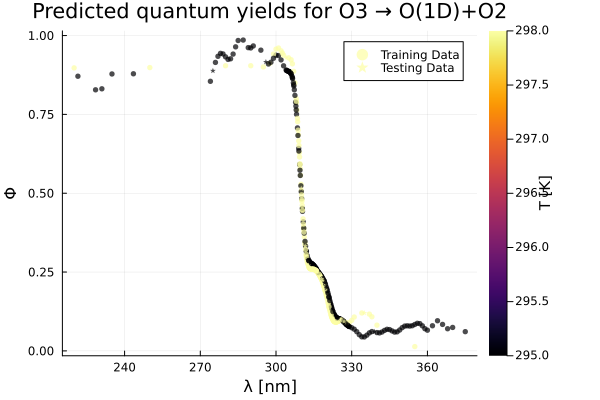

In [154]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted quantum yields for $(reaction)",
    label="Testing Data",
)


220.0
375.0


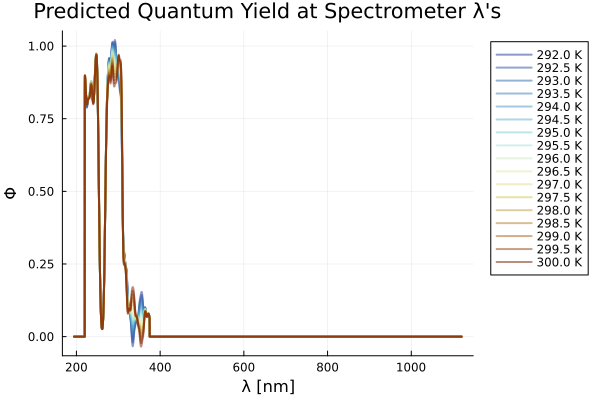

In [157]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_Φ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("Φ")
title!("Predicted Quantum Yield at Spectrometer λ's")